In [1]:
import os
import sys
import random
#import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
import uproot 
import time
from training_func import*
from matplotlib.colors import LogNorm


In [2]:
NEvent = 1000
PATH_FILE='/home/santilor/GPU_SupRes/PFlowNtupleFile_HOMDet_2to5GeV_Overlap_WS.root'

In [3]:
f = uproot.open(PATH_FILE)

In [4]:
f['EventTree'].keys()

[b'new_v',
 b'Cell_E',
 b'Total_Ch_Energy',
 b'Total_Nu_Energy',
 b'True_Ch_Energy',
 b'True_Nu_Energy',
 b'Smeared_Ch_Energy',
 b'Trk_X_indx',
 b'Trk_Y_indx',
 b'Trk_X_pos',
 b'Trk_Y_pos',
 b'Trk_Theta',
 b'Trk_Phi',
 b'Pi0_X_pos',
 b'Pi0_Y_pos',
 b'Pi0_Theta',
 b'Pi0_Phi',
 b'Photon1_E',
 b'Photon2_E',
 b'Photon1_Theta',
 b'Photon2_Theta',
 b'Photon1_Phi',
 b'Photon2_Phi',
 b'cell_Energy',
 b'cellCh_Energy',
 b'cellNu_Energy',
 b'Noise_cell_Energy']

In [10]:
true_pix, orig_pix, det_size = 128, 64, 125.
LayerPix = np.array([64, 32])
supL=np.array([64, 64])
No_Lay=np.array([13,34])

In [6]:
print("Read TTree - ", NEvent)


Read TTree -  1000


In [7]:
#NU
start = time.time()
Nu_Layer_Orig = [f['EventTree'].array('cellNu_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0,int(NEvent/1000)  )] 
Nu_Layer_Orig = np.stack(Nu_Layer_Orig, axis=0)
Nu_Layer_Orig = Nu_Layer_Orig.reshape(NEvent, 6, true_pix, true_pix)
end = time.time()
print(end-start, "Nu import")


7.639444589614868 Nu import


In [8]:
#CH
start = time.time()
Ch_Layer_Orig = [f['EventTree'].array('cellCh_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0,int(NEvent/1000)  )] 
Ch_Layer_Orig = np.stack(Ch_Layer_Orig, axis=0)[:, :, :2]
Ch_Layer_Orig = Ch_Layer_Orig.reshape(NEvent, 2, true_pix, true_pix)
end = time.time()
print(end-start, "Ch import")

2.184356927871704 Ch import


In [9]:
### --- MAKE ORIG RESOLUTION : [64,64]--- ###
start = time.time()
Ch_ori=np.asarray([ [SumPixel(Ch_Layer_Orig[ev][i], orig_pix) for i in range(2)] for ev in range(NEvent)])
Nu_ori=np.asarray([ [SumPixel(Nu_Layer_Orig[ev][i], orig_pix) for i in range(2)] for ev in range(NEvent)])
end = time.time()
print(end-start, "Make Orig Res")

65.3239324092865 Make Orig Res


In [11]:
### --- SMEAR ORIG RESOLUTION : [64,64]--- ###
start = time.time()
Ch_ori=np.asarray([[SmearImage(Ch_ori[ev][i][:orig_pix,:orig_pix]) for i in range(2)] for ev in range(NEvent) ])
Nu_ori=np.asarray([[SmearImage(Nu_ori[ev][i][:orig_pix,:orig_pix]) for i in range(2)] for ev in range(NEvent) ])
end = time.time()
print(end-start, "Smear Orig Res")
print(Ch_ori.shape)

7.544568777084351 Smear Orig Res
(1000, 2, 64, 64)


In [12]:
### --- MAKE REAL RESOLUTION : [64,32] --- ###
start = time.time()
Ch_real=np.asarray([ [SumPixel(Ch_ori[ev][i], LayerPix[i]) for i in range(2)] for ev in range(NEvent)])
Nu_real=np.asarray([ [SumPixel(Nu_ori[ev][i], LayerPix[i]) for i in range(2)] for ev in range(NEvent)])
end = time.time()
print(end-start, "Make Real Res")
print(Ch_real.shape)

8.07624340057373 Make Real Res
(1000, 2)


In [45]:
Ch=[]
Nu=[]

for l in range(2):

    Ch_lay = []
    Nu_lay = []

    #Cell_lay = []
    
    for ev in range(NEvent):
        Ch_Cell=Ch_real[ev][l]
        Nu_Cell=Nu_real[ev][l]

        for X in range(LayerPix[l]):
            for Y in range(LayerPix[l]):
                if Ch_Cell[X][Y]>3*No_Lay[l]: 
                    Ch_lay.append(Ch_Cell[X][Y])
                if Nu_Cell[X][Y]>3*No_Lay[l]: 
                    Nu_lay.append(Nu_Cell[X][Y])
    Ch.append(np.asarray(Ch_lay))
    Nu.append(np.asarray(Nu_lay))

                

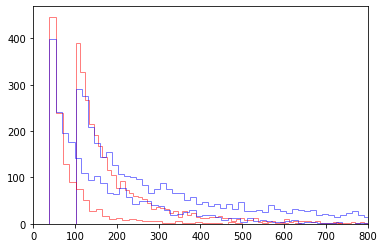

In [59]:
plt.hist(Ch[1],bins=200, alpha=0.5,color= "red",histtype='step', stacked=True)#, density=True)
plt.hist(Nu[1],bins=200, alpha=0.5, color="blue",histtype='step')#, density=True)
plt.hist(Ch[0],bins=50, alpha=0.5,color= "red",histtype='step', stacked=True)#, density=True)
plt.hist(Nu[0],bins=50, alpha=0.5, color="blue",histtype='step')#, density=True)
plt.xlim(0,800)
plt.show()